<a href="https://colab.research.google.com/github/cristianmejia00/clustering/blob/main/06_heatmap_sankey/01_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heatmap for Topic Modeling with BERTopic


# Requirements

## Packages installation and initialization

In [1]:
!pip install bertopic[visualization]

zsh:1: no matches found: bertopic[visualization]


In [1]:
import pandas as pd
import time
import math
from datetime import date
import uuid
import re
import os
import json
import pickle
from itertools import compress
from bertopic import BERTopic
from umap import UMAP
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
from sklearn.cluster import KMeans

/Users/cristian/Desktop/GitHub/clustering/env-tm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Change to the name of the folder in your Google Drive
root_folder_name = 'Bibliometrics_Drive'
#ROOT_FOLDER_PATH = f"drive/MyDrive/{root_folder_name}" # <- Google Colab
ROOT_FOLDER_PATH = f"/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/{root_folder_name}" #Mac

## Connect your Google Drive

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Function to save object to a pickle file
def save_object_as_pickle(obj, filename):
  """
  Saves an object as a pickle file.

  Args:
      obj: The object to be saved.
      filename: The filename of the pickle file.
  """
  with open(filename, "wb") as f:
    pickle.dump(obj, f)



In [4]:
# Function to load pickle object given a path
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


In [5]:
def save_heatmap_settings_as_json(heatmap_settings, filename="heatmap_settings.json"):
  """Saves heatmap settings as a JSON file with pretty indentation.

  Args:
      heatmap_settings: The heatmap settings dictionary.
      filename: The name of the JSON file.
  """
  with open(filename, "w") as f:
    json.dump(heatmap_settings, f, indent=4)



---



## PART 3: Merging Topic Models

# 🔴 Input files and options



In [11]:
heatmap_settings = {
    'metadata': {
      'heatmap_analysis_id': 'H012',
      'heatmap_name': 'Policy',
      'date': '2025-04-18',
      'created_by': 'cristianmejia00@gmail.com',
      'notes': '',
      'input_directory': '',
      'output_directory': ''
    },
    'global': {
                'min_cluster_size': 10,
                'seed': 100,
                'transformer_model': 'all-MiniLM-L6-v2',
                'sankey_threshold': 0.8
              },
    'inputs': [
        {
            'project_folder_name': 'Q327 TI Policy',
            'analysis_folder_name': 'a01_cn__f01_dc__c01_lv',
            'level_folder_name': 'level1',
            'embeddings_folder_name': 'f01/e01',
            'display_name': 'Policy_lv1',
            'cluster_column': 'Cluster Code',
            'heatmap_display_order': 0,
            'sankey_display_order': 1,
            'color': "#E9571F"
        }#,
        # {
        #     'project_folder_name': 'Q325_ai_libsci',
        #     'analysis_folder_name': 'a01_tm__f01_e01__km01',
        #     'embeddings_folder_name': 'f01/e01',
        #     'level_folder_name': 'level0',
        #     'display_name': 'AI',
        #     'cluster_column': 'Cluster Code',
        #     'heatmap_display_order': 1,
        #     'sankey_display_order': 0,
        #     'color': '#808080'
        # }#,
        # {
        #     'project_folder_name': 'Q282b_riken_com',
        #     'analysis_folder_name': 'a01_tm__f01_e01__km01',
        #     'embeddings_folder_name': 'f01/e01',
        #     'level_folder_name': 'level0',
        #     'display_name': 'RIKEN.Com',
        #     'cluster_column': 'Cluster Code',
        #     'heatmap_display_order': 3,
        #     'sankey_display_order': 2,
        #     'color': '#808080'
        # },
        # {
        #     'project_folder_name': 'Q312_utokyo',
        #     'analysis_folder_name': 'a01_tm__f01_e01__km01',
        #     'embeddings_folder_name': 'f01/e01',
        #     'level_folder_name': 'level0',
        #     'display_name': 'UTokyo',
        #     'cluster_column': 'Cluster Code',
        #     'heatmap_display_order': 4,
        #     'sankey_display_order': 1,
        #     'color': '#F2BA05'
        # }#,
        # # {
        # #     'project_folder_name': 'Q308_bio_plant',
        # #     'analysis_folder_name': 'a01_tm__f01_e01__km01',
        # #     'embeddings_folder_name': 'f01/e01',
        # #     'level_folder_name': 'level0',
        # #     'display_name': 'Plant',
        # #     'cluster_column': 'Cluster Code',
        # #     'heatmap_display_order': 4,
        # #     'sankey_display_order': 1,
        # #     'color': '#66FF00'
        # # }
      ]
}

In [12]:
analysis_folder = ""

if not os.path.exists(analysis_folder):
  print("We are here!")
  !mkdir $analysis_folder


# Save settings
save_heatmap_settings_as_json(heatmap_settings, filename=f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_settings_{heatmap_settings["metadata"]["heatmap_analysis_id"]}_{heatmap_settings["metadata"]["heatmap_name"]}.json')

We are here!
usage: mkdir [-pv] [-m mode] directory_name ...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/Bibliometrics_Drive/H012/heatmap_settings_H012_Policy.json'

In [15]:
f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}'

'/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/Bibliometrics_Drive/H012'

In [16]:
analysis_folder = f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}'

if not os.path.exists(analysis_folder):
  !mkdir $analysis_folder

mkdir: /Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My: Permission denied
mkdir: Drive/Bibliometrics_Drive: No such file or directory


In [17]:
# Save settings
save_heatmap_settings_as_json(heatmap_settings, filename=f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_settings_{heatmap_settings["metadata"]["heatmap_analysis_id"]}_{heatmap_settings["metadata"]["heatmap_name"]}.json')

In [19]:
heatmap_input_dfs = []
for tm in heatmap_settings['inputs']:
  document_path = f'{ROOT_FOLDER_PATH}/{tm["project_folder_name"]}/{tm["analysis_folder_name"]}/{tm["level_folder_name"]}/article_report.csv'
  print(document_path)
  input_df = pd.read_csv(document_path,
                         usecols=['ID', 'uuid', tm['cluster_column']])
  # Each dataset can use different clustering result e.g. X_C, level0, level1, so we need to unify the header name for concatenation
  input_df['display_name'] = tm['display_name']
  input_df['cluster'] = input_df['display_name'] + "-" + input_df[tm['cluster_column']].astype(str)
  input_df = input_df.rename(columns={'ID': 'UT'})
  input_df = input_df.drop(columns=[tm['cluster_column']])
  heatmap_input_dfs.append(input_df)

/Users/cristian/Library/CloudStorage/GoogleDrive-cristianmejia00@gmail.com/My Drive/Bibliometrics_Drive/Q327 TI Policy/a01_cn__f01_dc__c01_lv/level1/article_report.csv


In [20]:
document_info = pd.concat(heatmap_input_dfs).reset_index(drop=True)
print(len(document_info))
document_info.head()

28022


,UT,uuid,display_name,cluster
0,WOS:000602696600014,dd7ad71d-83cd-4de2-bfb8-461edd2048ab,Policy_lv1,Policy_lv1-1-1---
1,WOS:000775977600004,6c03794b-0a9e-4456-8e80-856d72f69b90,Policy_lv1,Policy_lv1-1-1---
2,WOS:000663415300053,df16beef-c79e-47fb-952c-4c3d850817fd,Policy_lv1,Policy_lv1-1-1---
3,WOS:000663439700002,f822ea4e-127c-429f-91b8-7037863e68d5,Policy_lv1,Policy_lv1-1-1---
4,WOS:000694940800015,c1a5c79f-7012-4af8-a16a-cb248d48f779,Policy_lv1,Policy_lv1-1-1---




---



## PART 5. Heatmap

In [21]:
# For firms we know, simply get the embeddings back.
embeddings_list = []
corpus_list = []
for tm in heatmap_settings['inputs']:
  print(f"=================Loading: {tm['project_folder_name']}")
  embeddings = load_pickle(f"{ROOT_FOLDER_PATH}/{tm['project_folder_name']}/{tm['embeddings_folder_name']}/embeddings.pck")
  if type(embeddings) == dict:
    print('Dict type found')
    embeddings = embeddings['embeddings']
  corpus_tmp = pd.read_csv(f"{ROOT_FOLDER_PATH}/{tm['project_folder_name']}/{tm['embeddings_folder_name']}/corpus.csv")

  embeddings_list.append(embeddings)
  corpus_list.append(corpus_tmp)

=================Loading: Q327 TI Policy
Dict type found


In [22]:
# Combine embeddings
embeddings_uploaded = np.vstack(embeddings_list)
corpus_uploaded = pd.concat(corpus_list).reset_index(drop=True)

In [23]:
embeddings_uploaded.shape

(74575, 384)

In [24]:
print(len(embeddings_uploaded))
print(len(corpus_uploaded))
print(len(document_info))

74575
74575
28022


In [25]:
# prompt: add `embeddings_uploaded` as a column to `corpus_uploaded`
corpus_uploaded['embeddings'] = list(embeddings_uploaded)

In [26]:
# prompt: remove  rows of corpus_uploaded where UT is duplicated

# Remove rows where 'UT' is duplicated, keeping the first occurrence
corpus_uploaded = corpus_uploaded.drop_duplicates(subset=['UT'], keep='first')

In [27]:
# prompt: merge `corpus_uploaded` and `document_info` by column UT. The merged data frame has as many rows and same sorting as corpus_uploaded. The merged data frame is named `full_corpus`.
full_corpus = pd.merge(document_info[['UT', 'uuid', 'cluster']], corpus_uploaded[['UT', 'text', 'embeddings']], on='UT', how='left')

In [28]:
len(full_corpus)

28022

In [29]:
len(document_info)

28022

In [30]:
# prompt: Remove all rows in full_corpus where the size of column `embeddings` do not match 384
full_corpus = full_corpus[full_corpus['embeddings'].apply(lambda x: len(x) == 384 if isinstance(x, list) or isinstance(x, np.ndarray) else False)]

In [31]:
len(full_corpus)

28022

In [32]:
# Remodel the topic model
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer

In [33]:
cluster_idx_mapping = full_corpus.cluster.value_counts()
cluster_idx_mapping = cluster_idx_mapping[cluster_idx_mapping >= heatmap_settings['global']['min_cluster_size']]
cluster_idx_mapping

cluster
Policy_lv1-99-99---    644
Policy_lv1-8-99---     549
Policy_lv1-1-1---      522
Policy_lv1-19-0---     484
Policy_lv1-20-0---     478
                      ... 
Policy_lv1-3-17---      45
Policy_lv1-5-14---      45
Policy_lv1-9-11---      45
Policy_lv1-14-6---      45
Policy_lv1-99-32---     45
Name: count, Length: 226, dtype: int64

In [34]:
full_corpus = full_corpus[full_corpus.cluster.isin(cluster_idx_mapping.index.to_list())]

In [35]:
len(full_corpus)

28022

In [36]:
# Form the embbedings
my_embeddings = np.vstack(full_corpus['embeddings'].tolist())

In [37]:
# get text and topics
docs = full_corpus.text
cluster_list = full_corpus.cluster

In [38]:
idx_cluster = [cluster_idx_mapping.index.get_loc(i) for i in cluster_list]

In [39]:
len(idx_cluster) == len(docs) == len(my_embeddings)

True

# 🟢🟢

In [40]:
# Init "empty" models
embedding_model = SentenceTransformer(heatmap_settings["global"]["transformer_model"])
empty_dimensionality_model = BaseDimensionalityReduction()
empty_cluster_model = BaseCluster()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        ctfidf_model=ctfidf_model
)

In [41]:
topics, probs = topic_model.fit_transform(docs, my_embeddings, y=idx_cluster)

In [42]:
tm_summary = topic_model.get_topic_info()
tm_summary

,Topic,Count,Name,Representation,Representative_Docs
0,0,644,0_dialogue_oral_breastfeeding_disabilities,"[dialogue, oral, breastfeeding, disabilities, ...",[Policies on mental health in the workplace du...
1,1,549,1_sport_nutrition_food_healthy,"[sport, nutrition, food, healthy, foods, reces...",[Childhood overweight and obesity abatement po...
2,2,522,2_epu_uncertainty_firms_corporate,"[epu, uncertainty, firms, corporate, cash, inv...",[Does internal cash flowexternal financing sen...
3,3,484,3_wind_hydrogen_pv_ccs,"[wind, hydrogen, pv, ccs, ccus, solar, photovo...",[Renewable Energy Perspectives of Pakistan and...
4,4,478,4_education_teacher_cultural_educational,"[education, teacher, cultural, educational, te...",[Tackling racial equity in US schools A critic...
...,...,...,...,...,...
221,221,45,221_periurban_puls_familyfriendly_humanwildlife,"[periurban, puls, familyfriendly, humanwildlif...",[Policy instruments as a trigger for urban spr...
222,222,45,222_trust_handwashing_compliance_conspiracy,"[trust, handwashing, compliance, conspiracy, p...",[Trust as a catalyst revealing the impact of g...
223,223,45,223_lcbs_waterpolicy_betweenperson_proenvironm...,"[lcbs, waterpolicy, betweenperson, proenvironm...",[Impact of energy policies on residential lowc...
224,224,45,224_ukraine_eus_csdp_japans,"[ukraine, eus, csdp, japans, cfsp, defence, in...",[Rethinking change in Japanaposs security poli...


In [43]:
# Document information. Including the topic assignation
test = topic_model.get_document_info(docs, df = full_corpus)
test = test[['cluster', 'Name']].drop_duplicates(subset=['cluster'], keep='first')
test['short_name'] = test['Name'].str[:7]
test['dataset'] = test['cluster'].str.split('-').str[0]
print(test.shape)
test.head(10)

(226, 4)


,cluster,Name,short_name,dataset
0,Policy_lv1-1-1---,2_epu_uncertainty_firms_corporate,2_epu_u,Policy_lv1
522,Policy_lv1-1-2---,7_volatility_epu_stock_oil,7_volat,Policy_lv1
980,Policy_lv1-1-3---,13_cpu_uncertainty_climate_connectedness,13_cpu_,Policy_lv1
1344,Policy_lv1-1-4---,21_co_epu_rents_ardl,21_co_e,Policy_lv1
1631,Policy_lv1-1-5---,50_tpu_trade_export_uncertainty,50_tpu_,Policy_lv1
1774,Policy_lv1-1-6---,89_epu_corporate_gti_uncertainty,89_epu_,Policy_lv1
1865,Policy_lv1-1-99---,26_tourism_mpu_epu_uncertainty,26_tour,Policy_lv1
2135,Policy_lv1-2-1---,24_trading_cet_cetp_emission,24_trad,Policy_lv1
2409,Policy_lv1-2-2---,28_lccp_lowcarbon_pilot_city,28_lccp,Policy_lv1
2673,Policy_lv1-2-3---,45_synergy_air_pollution_ajpc,45_syne,Policy_lv1




---



In [68]:
# Default
# Visualize topic similarity using heatmap (self similarity)
hm = topic_model.visualize_heatmap(n_clusters=10)
#hm.write_html(f"{ROOT_FOLDER_PATH}/heatmap_updated.html")
hm

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_dialogue_oral_breastfeeding, 1_sport_nutrition_food,
                    15_palliative_double_transfer, ...,
                    177_tobacco_nicotine_cigare..., 184_medicines_biosimilar_bi...,
                    204_abac_xacml_access],
              'xaxis': 'x',
              'y': [0_dialogue_oral_breastfeeding, 1_sport_nutrition_food,
                    15_palliative_double_transfer, ...,
                    177_tobacco_nicotine_cigare..., 184_medicines_biosimilar_bi...,
                    204_abac_xacml_access],
              'yaxis': 'y',
              'z': array([[0.99999976, 0.8064317 , 0.88294494, ..., 0.5537442 , 0.5521407 ,
                           0.32008982],
                          [0.8064317 , 1.0000001 , 0.7919127 , ..., 0.64877117, 0.5899657 ,
                           0.24773219],
                          [0.88294494, 0.7919127 , 0.9999999 , ..., 0.48932797, 0.49530002,
                           0.22831236],
                          ...,
                          [0.5537442 , 0.64877117, 0.48932797, ..., 1.        , 0.51394165,
                           0.15420204],
                          [0.5521407 , 0.5899657 , 0.49530002, ..., 0.51394165, 1.0000001 ,
                           0.22705045],
                          [0.32008982, 0.24773219, 0.22831236, ..., 0.15420204, 0.22705045,
                           0.9999999 ]], dtype=float32)}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Similarity Matrix</b>',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})

In [36]:
#pd.DataFrame(hm.data[0]['z'], columns=hm.data[0]['x']).to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_matrix.csv', index=False)



---



## coordinates

In [90]:
import numpy as np
import umap

def reduce_dimensionality(data):
    # Create a UMAP object with the desired settings
    reducer = umap.UMAP(n_components=2, random_state=heatmap_settings['global']['seed'], metric='cosine', min_dist=0.25)

    # Perform dimensionality reduction
    reduced_data = reducer.fit_transform(data)

    return reduced_data

In [86]:
# # Did not remember the reason for this one.
# label_dataset = []
# for i, label in enumerate(hm.data[0]['x']):
#     short_label = label[:7]
#     label_dataset.append(test[test['short_name'] == short_label]['dataset'].iloc[0])

# updated_matrix = []
# for this_line, current_sim_values in enumerate(hm.data[0]['z']):
#     updated_sim_values = [0 if label_dataset[i] == label_dataset[this_line] else x for i, x in enumerate(current_sim_values)]
#     updated_matrix.append(updated_sim_values)

# updated_matrix = np.array(updated_matrix)
# updated_matrix


In [91]:
# Reduce dimensionality using UMAP
reduced_data = reduce_dimensionality(hm.data[0]['z']) #hm.data[0]['z']
# Print the shape of the reduced data
print("Reduced data shape:", reduced_data.shape)

Reduced data shape: (226, 2)


In [92]:
dms = pd.DataFrame(reduced_data)
dms.columns = ['x', 'y']
dms['label'] = tm_summary['Name']
dms['cluster'] = dms['label'].map(test.set_index('Name')['cluster'])
dms.head()

,x,y,label,cluster
0,9.566925,4.645536,0_dialogue_oral_breastfeeding_disabilities,Policy_lv1-99-99---
1,11.962337,7.462266,1_sport_nutrition_food_healthy,Policy_lv1-8-99---
2,9.843314,6.345464,2_epu_uncertainty_firms_corporate,Policy_lv1-1-1---
3,11.671201,7.762243,3_wind_hydrogen_pv_ccs,Policy_lv1-19-0---
4,8.641847,3.690007,4_education_teacher_cultural_educational,Policy_lv1-20-0---


In [93]:
# Save dms
dms.to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/coordinates.csv', index = False)

In [94]:
# Save heatmap
pd.DataFrame(hm.data[0]['z'], columns=dms["cluster"]).to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_matrix.csv', index=False)

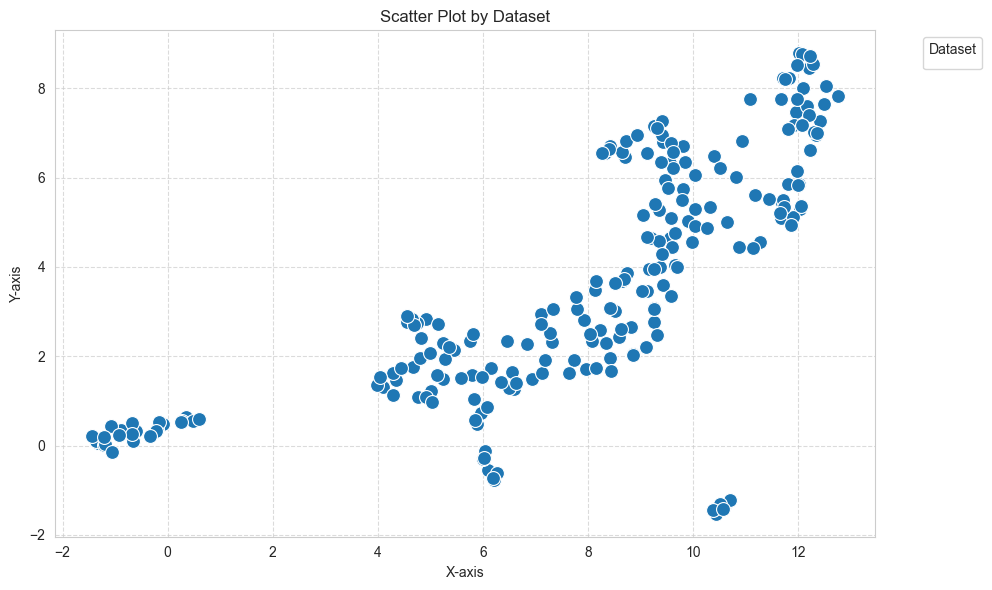

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with different colors for each dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dms, x='x', y='y', s=100)
plt.title('Scatter Plot by Dataset')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, linestyle='--', alpha=0.7)
# Add legend
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
# Improve appearance
sns.set_style("whitegrid")
plt.tight_layout()
# Show the plot
plt.show()



---



## Melted

In [52]:
# prompt: `hm_test` is a squared matrix similarity matrix. This is a symmetric matrix so we only consider the lower triangle, without the diagonal.  Let's get the melted form as a data frame with 3 columns `Source`, `Target`, and `Similarity`. Then, sort it from the largest similarity to the lowest. Remove the pairs with value of zero.
hm_test = hm.data[0]['z']

# Assuming hm_test is your similarity matrix
df = pd.DataFrame(hm_test)

# Get the lower triangle without the diagonal
rows, cols = np.tril_indices(df.shape[0], -1)

# Create a DataFrame with Source, Target, and Similarity
similarity_df = pd.DataFrame({
    'Source': df.columns[rows],
    'Target': df.columns[cols],
    'Similarity': df.values[rows, cols]
})

# Remove rows with similarity of zero
similarity_df = similarity_df[similarity_df['Similarity'] > 0]

# Sort by similarity in descending order
similarity_df = similarity_df.sort_values('Similarity', ascending=False)

similarity_df

,Source,Target,Similarity
4637,96,77,0.986254
11103,149,77,0.983651
11122,149,96,0.975077
674,37,8,0.974700
1022,45,32,0.974176
...,...,...,...
9994,141,124,0.002906
24101,220,11,0.002876
12647,159,86,0.002444
21385,207,64,0.001149


In [53]:
# prompt: Using dataframe similarity_df: Replace the values of columns Source and Target with the labels from `dms["cluster"]`

# Replace Source and Target with labels from dms["cluster"]
similarity_df['Source'] = similarity_df['Source'].map(lambda x: dms["cluster"][int(x)]) # Convert x to integer
similarity_df['Target'] = similarity_df['Target'].map(lambda x: dms["cluster"][int(x)]) # Convert x to integer


In [54]:
similarity_df.head(100)

,Source,Target,Similarity
4637,Policy_lv1-18-3---,Policy_lv1-18-2---,0.986254
11103,Policy_lv1-18-4---,Policy_lv1-18-2---,0.983651
11122,Policy_lv1-18-4---,Policy_lv1-18-3---,0.975077
674,Policy_lv1-5-1---,Policy_lv1-5-99---,0.974700
1022,Policy_lv1-2-3---,Policy_lv1-2-99---,0.974176
...,...,...,...
18875,Policy_lv1-5-13---,Policy_lv1-5-10---,0.932928
524,Policy_lv1-2-99---,Policy_lv1-2-2---,0.931119
19587,Policy_lv1-4-17---,Policy_lv1-4-7---,0.931101
19639,Policy_lv1-4-17---,Policy_lv1-4-11---,0.930927


In [99]:
# # prompt: Using dataframe similarity_df: Replace the values of columns Source and Target with the corresponding "cluster" in the `dms` data frame. Use the column "label" in `dms` to find the matches.

# # Assuming you have a dataframe named 'dms' with 'label' and 'cluster' columns

# # Create a dictionary mapping 'label' to 'cluster' from the 'dms' dataframe
# label_to_cluster = dict(zip(dms['label'], dms['cluster']))

# # Replace 'Source' column values with corresponding 'cluster' values
# similarity_df['Source'] = similarity_df['Source'].map(label_to_cluster)

# # Replace 'Target' column values with corresponding 'cluster' values
# similarity_df['Target'] = similarity_df['Target'].map(label_to_cluster)

# similarity_df.head()

In [55]:
similarity_df.to_csv(f'{ROOT_FOLDER_PATH}/{heatmap_settings["metadata"]["heatmap_analysis_id"]}/heatmap_melted.csv', index = False)

In [66]:
#!pip install matplotlib
#!pip install seaborn

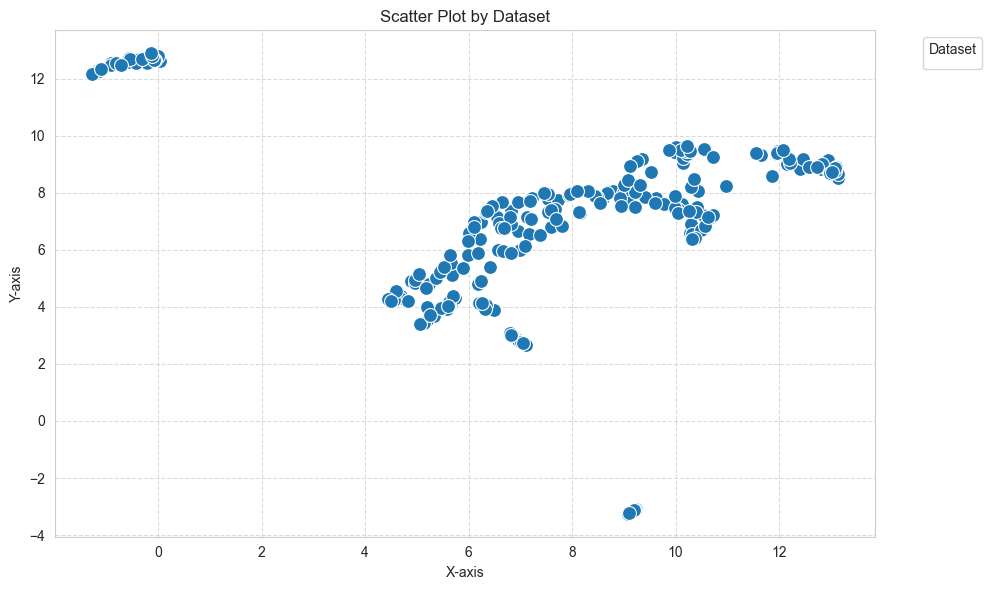